In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
# we import funcanimation from the matplotlib library
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from IPython.display import HTML
import ccxt
import datetime
import pandas as pd
from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime, timedelta
# we hide warnings in the notebook
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.ndimage import gaussian_filter1d


In [4]:
from datetime import datetime

def convert_unix_to_datetime(unix_timestamp):
    # Convert Unix timestamp to datetime object
    dt = datetime.utcfromtimestamp(unix_timestamp)
    converted_datetime_str = dt.strftime('%Y-%m-%d')
    return dt

# Example usage
unix_timestamp = 1631021642  # Example Unix timestamp
converted_datetime = convert_unix_to_datetime(unix_timestamp)
print(f"Unix Timestamp: {unix_timestamp}")
print(f"Converted Datetime (UTC): {converted_datetime}")
# we also return a string with the date in the format YYYY-MM-DD
converted_datetime_str = converted_datetime.strftime('%Y-%m-%d')
print(f"Converted Datetime (UTC) as string: {converted_datetime_str}")


Unix Timestamp: 1631021642
Converted Datetime (UTC): 2021-09-07 13:34:02
Converted Datetime (UTC) as string: 2021-09-07


In [5]:
from datetime import datetime

def unix_timestamp_to_date(unix_timestamp):
    """
    Convert a Unix timestamp to a date (without time).

    Parameters:
    - unix_timestamp: An integer or float representing the Unix timestamp.

    Returns:
    - A datetime.date object representing the date.
    """
    # Convert the Unix timestamp to a datetime object
    dt_object = datetime.utcfromtimestamp(unix_timestamp)
    
    # Extract and return just the date part
    return dt_object.date()

# Example usage:
unix_timestamp = 1708128000  # Example Unix timestamp
date = unix_timestamp_to_date(unix_timestamp)
print(f"Date: {date}")


Date: 2024-02-17


In [6]:

cg = CoinGeckoAPI()

def fetch_historical_data(coin_id, days='max', interval='daily'):
    """
    Fetch historical market data for a specific coin from CoinGecko.
    
    :param coin_id: The CoinGecko ID of the coin (e.g., 'bitcoin').
    :param days: The number of days of historical data to fetch ('max' for as much as possible).
    :param interval: The interval of the data ('daily').
    :return: A DataFrame with the historical data.
    """
    data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=days, interval=interval)
    # print(data['prices'])
    # print(data['prices'][0])
    dates = [unix_timestamp_to_date(ms[0]/1000) for ms in data['prices']]
    # print(dates)
    prices = [price[1] for price in data['prices']]
    # print(prices)
    # we convert timestamp 1550707200000 to datetime
    # datetime.fromtimestamp(1708128000000/1000.0)
    # print(datetime.fromtimestamp(1550707200000/1000.0))
    # print(pd.to_datetime(1708128000000/1000).date().strftime('%Y-%m-%d'))
    
    df = pd.DataFrame(data={'date': dates, 'price': prices})
    return df

# # Example usage:
# coin_id = 'bitcoin'  # Use the CoinGecko ID for the cryptocurrency
# data = fetch_historical_data(coin_id, days='3')  # Last 5 years
# print(data.head(10))

# Note: To fetch data for the top 100 crypto assets, you would need to know their CoinGecko IDs.
# You can use `cg.get_coins_markets(vs_currency='usd')` to fetch a list of coins with their IDs,
# and then iterate over the ones you're interested in.


In [7]:
#  we retrieve 5 years of data for the following coins: 'bitcoin', 'ethereum', 'ripple', 'litecoin', 'dogecoin'
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']

prices_df_0 = pd.DataFrame(columns=['date', 'price', 'coin'])

for coin in coins:
    historical_data = fetch_historical_data(coin, days='3000')
    # we get rid of the last reading as it is today's price and it is not complete
    historical_data = historical_data.iloc[:-1]
    historical_data['coin'] = coin
    prices_df_0 = pd.concat([prices_df_0, historical_data])
    # we sleep for 1 second to avoid hitting the CoinGecko API rate limits
    time.sleep(1)

prices_df_0.tail(10)

,date,price,coin
2285,2024-02-11,18.943746,chainlink
2286,2024-02-12,20.111251,chainlink
2287,2024-02-13,20.496025,chainlink
2288,2024-02-14,19.878042,chainlink
2289,2024-02-15,20.266400,chainlink
2290,2024-02-16,19.947655,chainlink
2291,2024-02-17,19.567520,chainlink
2292,2024-02-18,20.033304,chainlink
2293,2024-02-19,20.089966,chainlink
2294,2024-02-20,19.823360,chainlink


In [8]:
# we pivot the dataframe and get the coin into columns
prices_pivot = prices_df_0.pivot(index='date', columns='coin', values='price')
prices_pivot.tail(10)

coin,bitcoin,chainlink,ethereum,solana,uniswap
date,,,,,
2024-02-11,47768.995251,18.943746,2499.492184,108.991461,6.624057
2024-02-12,48189.881793,20.111251,2505.076808,107.423813,6.673340
2024-02-13,50050.136095,20.496025,2657.990408,112.036818,6.843330
2024-02-14,49732.145370,19.878042,2641.536097,112.599112,6.693592
2024-02-15,51790.169298,20.266400,2780.372975,116.976107,6.873956
2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789
2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381
2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282
2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406


In [9]:
# prices_pivot.head()
# reset the index in place to get the date as a column
prices_pivot.reset_index(inplace=True)
prices_pivot.head()

coin,date,bitcoin,chainlink,ethereum,solana,uniswap
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN


In [10]:
def get_daily_returns(returns_df,coin):
    daily_returns = returns_df.copy()
    # for each row we calculate how many days since date of previous row
    daily_returns['days_since'] = daily_returns['date'].diff().dt.days
    # we calculate the daily return by undoing the cumulative product
    # for each row after the first one, we calculate the daily return as the nth root of the cumulative (1 + return) product
    daily_returns['gross_return'] = daily_returns[coin] / daily_returns[coin].shift(1)
    daily_returns['daily_return'] = daily_returns['gross_return'] ** (1 / daily_returns['days_since'])-1
    # we check if the daily return is correct by calculating the cumulative product doing (1 + daily_return	) ** days_since
    # daily_returns['gross_check'] = ( daily_returns['daily_return']) ** daily_returns['days_since']
    # we fill the first row with 1
    # daily_returns['daily_return'].iloc[0] = 1
    
    # return daily_returns
    return daily_returns['daily_return'].to_list()


# get_daily_returns(merged_df[['Date','spy_close']]).head()
# print(get_daily_returns(merged_df[['Date','spy_close']]))
    

    

In [11]:
# for each column in the dataframe we calculate the daily returns and add them as a new column with the name of the coin
for coin in coins:
    coin = coin 
    prices_pivot[f'{coin}_daily_return'] = get_daily_returns(prices_pivot[['date', coin]],coin)
    # we also add the daily log1p return which we take from the daily return that we have just calculated
    prices_pivot[f'{coin}_daily_log1p_return'] = np.log1p(prices_pivot[f'{coin}_daily_return'])

prices_pivot.head(10)

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN,NaN,NaN,-0.034226,-0.034825,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN,0.000873,0.000873,-0.041009,-0.041874,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN,0.047102,0.046027,0.022607,0.022355,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN,0.010748,0.010690,-0.033001,-0.033558,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-12-10,416.910,NaN,0.847442,NaN,NaN,-0.001097,-0.001098,0.070233,0.067877,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-12-11,452.415,NaN,0.916739,NaN,NaN,0.085162,0.081730,0.081772,0.078600,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-12-12,434.903,NaN,0.971258,NaN,NaN,-0.038708,-0.039477,0.059471,0.057770,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-12-13,435.815,NaN,0.958303,NaN,NaN,0.002097,0.002095,-0.013339,-0.013428,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-12-14,443.277,NaN,0.995490,NaN,NaN,0.017122,0.016977,0.038805,0.038071,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#  we plot the daily returns for the 5 coins
fig = go.Figure()
for coin in coins:
    fig.add_trace(go.Scatter(x=prices_pivot['date'], y=prices_pivot[f'{coin}_daily_return'], mode='lines', name=coin))
fig.update_layout(title='Daily Returns', xaxis_title='Date', yaxis_title='Daily Return')
fig.show()


In [13]:
# we merge the two dataframes on the date column
# we make both date columns date only
# spy_df["Date"] = spy_df["Date"].dt.date
# btc_df_source["Date"] = btc_df_source["Date"].dt.date

# merged_df = pd.merge(spy_df, btc_df_source, on="Date", how="outer")
# we drop the na values
# merged_df = merged_df.dropna()
# we only keep the daily returns columns
# merged_df = merged_df[["Date", "spy_daily_return", "btc_daily_return"]]
# we rename the columns Close_x and Close_y to spy_close and btc_close
# merged_df = merged_df.rename(columns={"Close_x": "spy_close", "Close_y": "btc_close"})
merged_df = prices_pivot
merged_df.tail(10)

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2990,2024-02-11,47768.995251,18.943746,2499.492184,108.991461,6.624057,0.013273,0.013186,0.004679,0.004668,0.018288,0.018123,-0.005255,-0.005268,0.025008,0.024700
2991,2024-02-12,48189.881793,20.111251,2505.076808,107.423813,6.673340,0.008811,0.008772,0.002234,0.002232,-0.014383,-0.014488,0.007440,0.007412,0.061630,0.059806
2992,2024-02-13,50050.136095,20.496025,2657.990408,112.036818,6.843330,0.038603,0.037876,0.061041,0.059251,0.042942,0.042046,0.025473,0.025154,0.019132,0.018952
2993,2024-02-14,49732.145370,19.878042,2641.536097,112.599112,6.693592,-0.006353,-0.006374,-0.006191,-0.006210,0.005019,0.005006,-0.021881,-0.022124,-0.030151,-0.030615
2994,2024-02-15,51790.169298,20.266400,2780.372975,116.976107,6.873956,0.041382,0.040549,0.052559,0.051224,0.038872,0.038136,0.026946,0.026589,0.019537,0.019349
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [14]:
def get_pdf(data, bins, min_x=-0.4, max_x=0.4):
    bin_edges = np.linspace(min_x, max_x, bins + 1)  # bins + 1 because np.linspace includes both ends
    # data = np.clip(data, min_x, max_x)  # Clip the data to the range
    counts, _ = np.histogram(data, bins=bin_edges, density=True)  # Use density=True for PDF
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]  # Width of each bin
    counts = counts / counts.sum()

    return bin_centers, counts, bin_width

def find_month_starts(df, num_months=24):
    end_date = df['Date'].max()
    start_date = end_date - pd.DateOffset(months=num_months)
    month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')
    # make sure the date is a datetime and not a timestamp
    month_starts = month_starts.to_pydatetime()
    # print(month_starts)
    return month_starts

def percentage_formatter(x, pos):
    return '{:0.0f}%'.format(x*100)

In [15]:
# we try the new method of calculating annual returns using the daily returns and a monter carlo simulation

def generate_random_daily_returns_from_pdf(bin_centers, bin_counts, size=(500, 365)):
    # print('bin_centers:', bin_centers)
    # print('99 bin_counts:', bin_counts)
    probabilities = bin_counts / np.sum(bin_counts)
    daily_returns = np.random.choice(bin_centers, size=size, p=probabilities)
    return daily_returns

def simulate_annual_returns(daily_returns):
    annual_returns = np.prod(1 + daily_returns, axis=1) - 1
    return annual_returns

def get_annual_returns_pdf(annual_returns, bins=30):
    # Calculate the histogram of annual returns
    counts, bin_edges = np.histogram(annual_returns, bins=bins, density=True)
    # Calculate bin centers from edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0] 
    return bin_centers, counts, bin_width


In [16]:
merged_df.head()

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN,NaN,NaN,-0.034226,-0.034825,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN,0.000873,0.000873,-0.041009,-0.041874,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN,0.047102,0.046027,0.022607,0.022355,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN,0.010748,0.010690,-0.033001,-0.033558,NaN,NaN,NaN,NaN,NaN,NaN


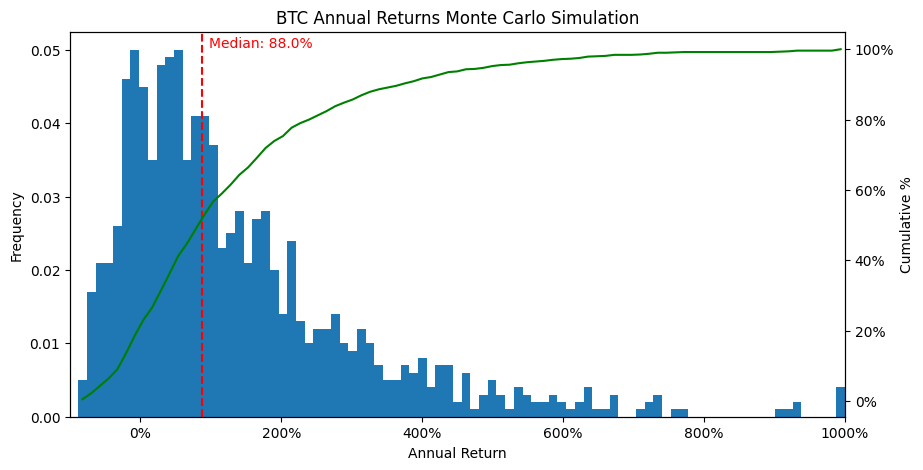

In [17]:
bins_daily = 600
bins_yearly = 88
tail = 3000
montecarlo_simulations = 1000
iterations_in_a_year = 365
min_x = -1
max_x = 10
min_x_daily = -0.5
max_x_daily = 1


bin_centers, bin_counts, bin_width = get_pdf(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
daily_montecarlo_returns = generate_random_daily_returns_from_pdf(bin_centers, bin_counts, size=(montecarlo_simulations, iterations_in_a_year))
annual_returns = simulate_annual_returns(daily_montecarlo_returns)
annual_returns = np.clip(annual_returns, min_x, max_x)
annual_centers, annual_counts, annual_width = get_annual_returns_pdf(annual_returns, bins=bins_yearly)
# we normalize the counts
annual_counts = annual_counts / annual_counts.sum()
# we clip the annual_centers between -1 and 2


# we add the cum_pct as a plot measured on the right y-axis
fig, ax = plt.subplots()

# we make the plot size bigger
fig.set_size_inches(10, 5)

ax.bar(annual_centers, annual_counts, width=annual_width)
ax.set_title('BTC Annual Returns Monte Carlo Simulation')
ax.set_xlabel('Annual Return')
ax.set_ylabel('Frequency')

# we add vertical bar for the 50th percentile
ax.axvline(np.percentile(annual_returns, 50), color='r', linestyle='--', label='50th percentile')
# we annotate the 50th percentile
median = np.percentile(annual_returns, 50)
ax.text(np.percentile(annual_returns, 50)*1.1, annual_counts.max(), 'Median: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')

# we calculate the cumulative percentage
cum_pct = np.cumsum(annual_counts)
# we plot the cumulative percentage
ax2 = ax.twinx()
ax2.plot(annual_centers, cum_pct, color='green', label='Cumulative %')
ax2.set_ylabel('Cumulative %')
ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
ax.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
# we set xlim from -1 to 5
ax.set_xlim(min_x, max_x)
# ax.set_ylim(0, bins/200) 
plt.show()


In [18]:

def get_stochastic_annual_median_return(merged_df, montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily=600, bins_yearly=88):
    # print(merged_df.tail(tail))
    bin_centers_btc, bin_counts_btc, bin_width_btc = get_pdf(merged_df, bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
    daily_montecarlo_returns_btc = generate_random_daily_returns_from_pdf(bin_centers_btc, bin_counts_btc, size=(montecarlo_simulations, iterations_in_a_year))
    annual_returns_btc = simulate_annual_returns(daily_montecarlo_returns_btc)
    annual_returns_btc_clipped = np.clip(annual_returns_btc, min_x, max_x)
    annual_centers_btc, annual_counts_btc, annual_bin_width = get_annual_returns_pdf(annual_returns_btc_clipped, bins=bins_yearly)
    # we normalize the counts
    annual_counts_btc = annual_counts_btc / annual_counts_btc.sum()
    median = np.percentile(annual_returns_btc, 50)

    return median, annual_centers_btc, annual_counts_btc, annual_bin_width, annual_returns_btc
# we clip the annual_centers between -1 and 2


posx and posy should be finite values
posx and posy should be finite values


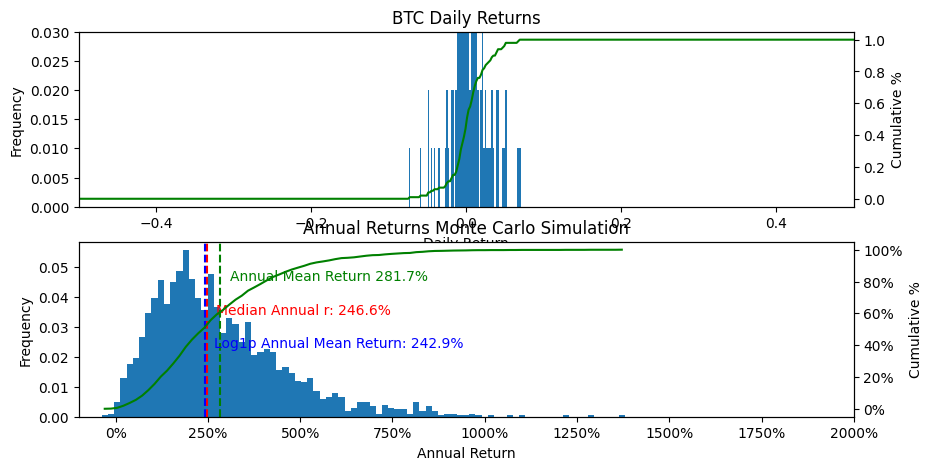

In [125]:
tail = 100
montecarlo_simulations = 2000
iterations_in_a_year = 365
min_x_daily = -0.5
max_x_daily = 0.5
bins_daily = 500
bins_yearly = 84
min_x = -1
max_x = 20

# we create two subplots, one with daily returns and one with annual returns on two rows and one column
fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(10, 10))

# we plot the daily returns
# fig, ax = plt.subplots()
bin_centers, bin_counts, bin_width = get_pdf(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
# ax.hist(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, density=True)
ax0.bar(bin_centers, bin_counts, width=bin_width)
ax0.set_title('BTC Daily Returns')
ax0.set_xlabel('Daily Return')
ax0.set_ylabel('Frequency')
ax0.set_xlim(min_x_daily, max_x_daily)
ax0.set_ylim(0, 0.03)

# we add vertical bar for the 50th percentile
ax0.axvline(np.percentile(merged_df['bitcoin_daily_return'], 50), color='r', linestyle='--', label='50th percentile')
median = np.percentile(merged_df['bitcoin_daily_return'], 50)
ax0.text(np.percentile(merged_df['bitcoin_daily_return'], 50)*1.1, ax.get_ylim()[1]*0.9, 'Median Annual Return: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')



# we calculate the cumulative percentage
cum_pct = np.cumsum(bin_counts)
ax2 = ax0.twinx()
ax2.plot(bin_centers, cum_pct, color='green', label='Cumulative %')
ax2.set_ylabel('Cumulative %')



median, annual_centers_btc, annual_counts_btc, bin_width_btc, annual_returns_btc = get_stochastic_annual_median_return(merged_df['bitcoin_daily_return'].tail(tail),montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)


# we plot the annual returns
# fig, ax = plt.subplots()
ax1.bar(annual_centers_btc, annual_counts_btc, width=bin_width_btc)
ax1.set_title('Annual Returns Monte Carlo Simulation')
ax1.set_xlabel('Annual Return')
ax1.set_ylabel('Frequency')

y_max = ax1.get_ylim()[1]*0.95

# we add vertical bar for the 50th percentile
ax1.axvline(np.percentile(annual_returns_btc, 50), color='r', linestyle='--', label='50th percentile')
# we annotate the 50th percentile
median = np.percentile(annual_returns_btc, 50)

# we add a green vertical line for the mean as the dot product of the bin_centers and bin_counts
mean = np.dot(annual_centers_btc, annual_counts_btc)
ax1.axvline(mean, color='g', linestyle='--', label='Mean')
ax1.text(mean*1.1, y_max*0.8, 'Annual Mean Return {:0.1%}'.format(mean), rotation=0, verticalalignment='bottom', c='g')

# we add the log1p mean return as a vertical line
log1p_mean = np.dot(np.log1p(annual_centers_btc), annual_counts_btc)
log_mean = np.expm1(log1p_mean)
ax1.axvline(log_mean, color='b', linestyle='--', label='Log Mean')
ax1.text(log_mean*1.1, y_max*0.4, 'Log1p Annual Mean Return: {:0.1%}'.format(log_mean), rotation=0, verticalalignment='bottom', c='b')





ax1.text(np.percentile(annual_returns_btc, 50)*1.1, y_max*0.6, 'Median Annual r: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')

# we calculate the cumulative percentage
cum_pct = np.cumsum(annual_counts_btc)
# we plot the cumulative percentage
ax12 = ax1.twinx()
ax12.plot(annual_centers_btc, cum_pct, color='green', label='Cumulative %')
ax12.set_ylabel('Cumulative %')
ax12.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
ax12.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# we set xlim from -1 to 5
ax1.set_xlim(min_x, max_x)
fig.set_size_inches(10, 5)



plt.show()


In [20]:
# we rename date to Date
merged_df = merged_df.rename(columns={"date": "Date"})
merged_df.tail()

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [21]:
print(coins)

['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']


In [22]:

def add_annual_stochastic_returns(date,merged_df, annualization_window_tail_days,information_window_tail_days, montecarlo_simulations, coins, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly):
    date = pd.to_datetime(date)
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    merged_df=merged_df[merged_df['Date'] <= date]
    min_tail_date = date - pd.DateOffset(days=annualization_window_tail_days+information_window_tail_days)
    merged_df=merged_df[(merged_df['Date'] >= min_tail_date)]
   

    for coin in coins:

        # print(tail_date)

        # for row in merged_df[(merged_df['Date'] >= tail_date) & (merged_df['Date'] <= date)].itertuples():
        for row in merged_df.itertuples():
            date = row.Date
            median_yearly, _, _,_, _ = get_stochastic_annual_median_return(merged_df[coin+'_daily_return'], montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
            merged_df.loc[merged_df['Date'] == date, coin+'_yearly_return'] = median_yearly
        
    return merged_df


In [23]:
tail = 90 #days of data to use to estimate the yearly returns using the montecarlo simulation
montecarlo_simulations = 1000
iterations_in_a_year = 365
min_x = -1
max_x = 10
min_x_daily = -0.5
max_x_daily = 1
bins_daily = 600
bins_yearly = 90
swan_size = -1
swan_frequency = 1/10
information_window_tail_days = 5
annualization_window_tail_days = 5
y_max = 0.5

date_test = pd.to_datetime('2024-01-01').date()
df = add_annual_stochastic_returns(date_test,merged_df, annualization_window_tail_days,information_window_tail_days, montecarlo_simulations, coins, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
df.tail(15)

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,...,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return,bitcoin_yearly_return,ethereum_yearly_return,solana_yearly_return,uniswap_yearly_return,chainlink_yearly_return
2939,2023-12-22,43849.699599,15.279277,2236.186962,93.938076,6.169052,0.004941,0.004928,0.017178,0.017033,...,0.134716,0.040970,0.040153,0.075346,0.072642,-0.679126,2.828604,843.989807,618.883899,3.896975
2940,2023-12-23,44003.696022,15.497920,2327.048963,98.078002,6.401297,0.003512,0.003506,0.040633,0.039829,...,0.043127,0.037647,0.036956,0.014310,0.014208,-0.683669,2.655601,969.611277,627.041984,3.917017
2941,2023-12-24,43752.030885,15.681732,2310.955663,107.639817,6.334079,-0.005719,-0.005736,-0.006916,-0.006940,...,0.093028,-0.010501,-0.010556,0.011860,0.011791,-0.685160,2.824754,913.656313,622.687917,3.730623
2942,2023-12-25,43034.971063,15.291259,2264.911144,112.448358,6.854675,-0.016389,-0.016525,-0.019924,-0.020126,...,0.043703,0.082190,0.078986,-0.024900,-0.025215,-0.686722,2.911710,797.464270,626.965718,3.896518
2943,2023-12-26,43638.236302,15.612646,2273.632612,121.446593,6.972945,0.014018,0.013921,0.003851,0.003843,...,0.076981,0.017254,0.017107,0.021018,0.020800,-0.679519,2.748395,901.466581,594.248013,3.985748
2944,2023-12-27,42516.426940,15.068265,2230.876184,112.325516,7.314333,-0.025707,-0.026043,-0.018805,-0.018984,...,-0.078074,0.048959,0.047798,-0.034868,-0.035490,-0.684642,2.670274,933.789068,613.066389,4.076367
2945,2023-12-28,43418.467775,16.642370,2376.771249,106.977054,7.242607,0.021216,0.020994,0.065398,0.063349,...,-0.048787,-0.009806,-0.009855,0.104465,0.099361,-0.686835,2.783140,902.779660,631.508322,4.160997
2946,2023-12-29,42600.650633,16.051461,2345.260709,102.253825,7.785611,-0.018836,-0.019015,-0.013258,-0.013346,...,-0.045156,0.074974,0.072296,-0.035506,-0.036152,-0.687324,2.852197,910.324508,622.120089,3.792954
2947,2023-12-30,42074.707156,15.528248,2299.526207,106.252561,7.564944,-0.012346,-0.012423,-0.019501,-0.019693,...,0.038361,-0.028343,-0.028752,-0.032596,-0.033139,-0.684414,2.757716,921.030242,638.366460,4.086803
2948,2023-12-31,42220.611401,15.197977,2294.344006,101.988835,7.387026,0.003468,0.003462,-0.002254,-0.002256,...,-0.040956,-0.023519,-0.023800,-0.021269,-0.021498,-0.686451,2.715216,937.724119,629.425696,3.958563


In [24]:
df.tail(65)

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,...,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return,bitcoin_yearly_return,ethereum_yearly_return,solana_yearly_return,uniswap_yearly_return,chainlink_yearly_return
2939,2023-12-22,43849.699599,15.279277,2236.186962,93.938076,6.169052,0.004941,0.004928,0.017178,0.017033,...,0.134716,0.040970,0.040153,0.075346,0.072642,-0.679126,2.828604,843.989807,618.883899,3.896975
2940,2023-12-23,44003.696022,15.497920,2327.048963,98.078002,6.401297,0.003512,0.003506,0.040633,0.039829,...,0.043127,0.037647,0.036956,0.014310,0.014208,-0.683669,2.655601,969.611277,627.041984,3.917017
2941,2023-12-24,43752.030885,15.681732,2310.955663,107.639817,6.334079,-0.005719,-0.005736,-0.006916,-0.006940,...,0.093028,-0.010501,-0.010556,0.011860,0.011791,-0.685160,2.824754,913.656313,622.687917,3.730623
2942,2023-12-25,43034.971063,15.291259,2264.911144,112.448358,6.854675,-0.016389,-0.016525,-0.019924,-0.020126,...,0.043703,0.082190,0.078986,-0.024900,-0.025215,-0.686722,2.911710,797.464270,626.965718,3.896518
2943,2023-12-26,43638.236302,15.612646,2273.632612,121.446593,6.972945,0.014018,0.013921,0.003851,0.003843,...,0.076981,0.017254,0.017107,0.021018,0.020800,-0.679519,2.748395,901.466581,594.248013,3.985748
2944,2023-12-27,42516.426940,15.068265,2230.876184,112.325516,7.314333,-0.025707,-0.026043,-0.018805,-0.018984,...,-0.078074,0.048959,0.047798,-0.034868,-0.035490,-0.684642,2.670274,933.789068,613.066389,4.076367
2945,2023-12-28,43418.467775,16.642370,2376.771249,106.977054,7.242607,0.021216,0.020994,0.065398,0.063349,...,-0.048787,-0.009806,-0.009855,0.104465,0.099361,-0.686835,2.783140,902.779660,631.508322,4.160997
2946,2023-12-29,42600.650633,16.051461,2345.260709,102.253825,7.785611,-0.018836,-0.019015,-0.013258,-0.013346,...,-0.045156,0.074974,0.072296,-0.035506,-0.036152,-0.687324,2.852197,910.324508,622.120089,3.792954
2947,2023-12-30,42074.707156,15.528248,2299.526207,106.252561,7.564944,-0.012346,-0.012423,-0.019501,-0.019693,...,0.038361,-0.028343,-0.028752,-0.032596,-0.033139,-0.684414,2.757716,921.030242,638.366460,4.086803
2948,2023-12-31,42220.611401,15.197977,2294.344006,101.988835,7.387026,0.003468,0.003462,-0.002254,-0.002256,...,-0.040956,-0.023519,-0.023800,-0.021269,-0.021498,-0.686451,2.715216,937.724119,629.425696,3.958563


In [25]:

# Define the find_nearest function
def find_nearest(all_dates, target_date):
    # Calculate the absolute difference between each date in all_dates and the target_date
    differences = [abs(date - target_date) for date in all_dates]
    # Find the index of the smallest difference
    index_nearest = differences.index(min(differences))
    return index_nearest



In [26]:
def add_swan(bin_centers, counts, swan_size, swan_frequency):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    if swan_frequency > 0:
        # swan_size = -(1-1e-6) if swan_size == -1 else swan_size
        bin_centers.append((swan_size))
        counts.append(swan_frequency)
        # we normalize the array_2
        counts = np.array(counts) / np.sum(counts)
    # bin_centers_spy = np.sort(bin_centers_spy)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)
    return bin_centers, counts

def add_log_swan(bin_centers, counts, swan_size, swan_frequency, swan_f):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    
    if swan_frequency > 0:
        bin_centers.append(np.log1p(swan_size*swan_f))
        counts.append(swan_frequency)
        counts = np.array(counts) / np.sum(counts)
        
    return bin_centers, counts

HOLA GERMÀ - NECESSITES EN AQUEST PUNT QUE UPDATE 8 generi 3 coses verticals per barba

In [27]:
merged_df.tail()

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [235]:

def get_3charts(date,merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,frame_prefix=None):
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    date = pd.to_datetime(date)

    information_window_df = merged_df[merged_df['Date'] < date]
    information_window_df = information_window_df.tail(information_window_tail_days)
    fig, (ax0, ax1,  ax5) = plt.subplots(3, 1, figsize=(8, 6))

    for coin in coins:
        index_for = coins.index(coin)
        # prep chart 1
        bin_centers, counts, bin_width = get_pdf(information_window_df[coin+'_daily_return'], bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
        bin_centers, counts = add_swan(bin_centers, counts, swan_size, swan_frequency)
        ax0.bar(bin_centers, counts, width=bin_width*2, align='center')  # align='center' to center the bars
        ax0.set_title(f"Daily Returns PDFs last {information_window_tail_days} days ending in {date.strftime('%Y-%m-%d')}")
        ax0.set_xlim(min_x_daily*0.5, max_x_daily*0.2)
        y_max = 0.2
        ax0.set_ylim(0.001, y_max)
        ax0.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

        # prep chart 2
        median, annual_centers, annual_counts, annual_bin_width, annual_returns = get_stochastic_annual_median_return(information_window_df[coin+'_daily_return'],montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
        bin_centers_log = np.log1p(annual_centers)
        mean = np.dot(annual_centers, annual_counts)
        log_mean = np.dot(bin_centers_log, annual_counts)
        log_mean_e = np.expm1(log_mean)
        bin_centers, counts = add_swan(annual_centers, annual_counts, swan_size, swan_frequency)

        # prep chart 3
        exp_g_array = []
        fr = np.linspace(0,1,bin_kelly_fractions)
        for f in fr:
            bin_centers_f = annual_centers * f
            bin_c = np.log1p(bin_centers_f)
            bin_centers_f, counts_f = add_log_swan(bin_c, annual_counts, swan_size, swan_frequency, swan_f=f)
            exp_g = np.dot(bin_centers_f, counts_f)
            exp_g = np.expm1(exp_g)
            exp_g_array.append(exp_g)

        ax1.bar(bin_centers, counts, width=annual_bin_width, align='center')  # align='center' to center the bars
        ax1.set_title(f"Annual Return PDFs last {information_window_tail_days} days ending in {date.strftime('%Y-%m-%d')}")
        ax1.set_xlim(min_x, max_x)
        ax1.set_ylim(0.001, y_max/4)
        ax1.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax1.axvline(x=log_mean_e, color='g' if log_mean_e > 0 else 'r', linestyle='--', label='Mean return')
        ax1.text(log_mean_e, y_max/4*0.9*(1-0.1*index_for), f"mean annual return {coin}: {log_mean_e*100:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right' if log_mean_e > 0.5 * max_x else 'left', color='g' if mean > 0 else 'r')
        ax1.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        

        
        ax5.plot(fr, exp_g_array)
        ax5.set_title(f"Expected G as function of fraction")
        ax5.set_xlim(0, 1)
        ax5.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        max_g = np.max(exp_g_array)
        ax5_ymax =20
        max_f = fr[np.argmax(exp_g_array)]
        ax5.axvline(x=max_f, color='g', linestyle='--', label='Max G')
        ax5.text(max_f, max_g if max_g < ax5_ymax else ax5_ymax, f"Opt f {coin}: {max_f*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g')
        ax5.set_ylim(-1,ax5_ymax)
        ax5.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        # we set the y axis to be logarithmic
        # ax5.set_yscale('log')
        
    plt.tight_layout() 
    # ax1.legend(coins)
    # ax5.legend(coins)

    fig.savefig(f"{frame_prefix}_ax1.png")
    return fig, ax0, ax1, ax5
    


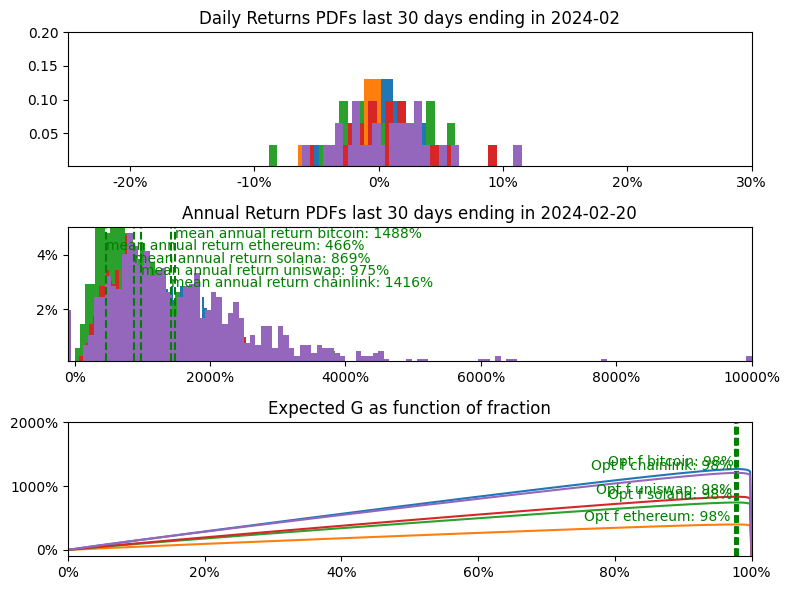

In [227]:
calc_date = pd.to_datetime('2024-02-20').date()
# tail = 100
montecarlo_simulations = 1000
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']
min_x = -1
max_x = 100
bins_yearly = 120
min_x_daily = -0.5
max_x_daily = 1.5
bins_daily = 600
bin_kelly_fractions = 500

swan_size = -1
swan_frequency = 1/50
# y_max = 0.3

information_window_tail_days = 30



# merged_df_annualized = add_annual_stochastic_returns(calc_date, merged_df, annualization_window_tail_days,information_window_tail_days, montecarlo_simulations, coins, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)

fig, ax1, ax3, ax5 = get_3charts(calc_date, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions)



In [230]:
from datetime import timedelta

# Original date
calc_date = pd.to_datetime('2024-02-01').date()

# Advance date by 3 days
calc_date += timedelta(days=3)


In [ ]:
def generate_and_save_frames(date, frame_prefix):
    # Placeholder for actual chart generation and frame saving
    # For each day, generate charts and save as images
    fig, ax1, ax3, ax5 = plt.figure(), plt.figure(), plt.figure()  # Simulate get_3charts output
    fig.savefig(f"{frame_prefix}_ax1.png")
    ax1.savefig(f"{frame_prefix}_ax2.png")
    ax3.savefig(f"{frame_prefix}_ax3.png")
    # ax5 would be saved similarly

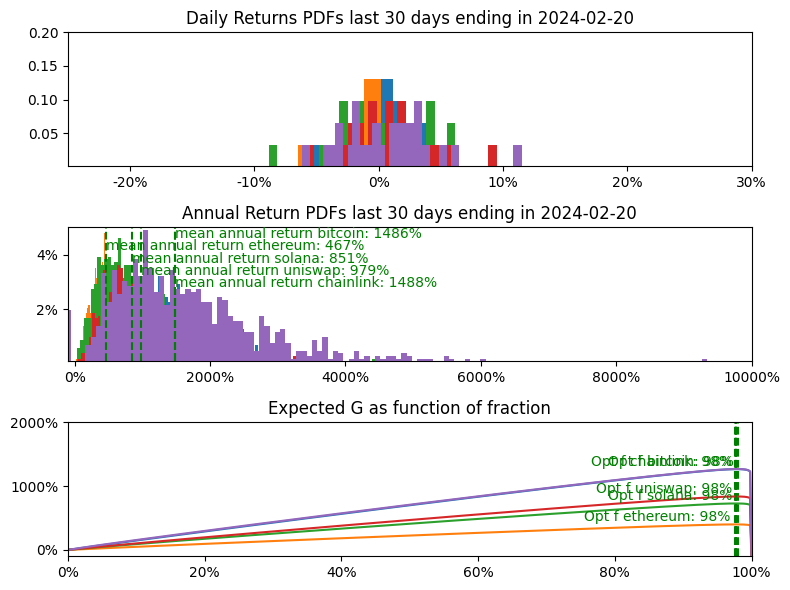

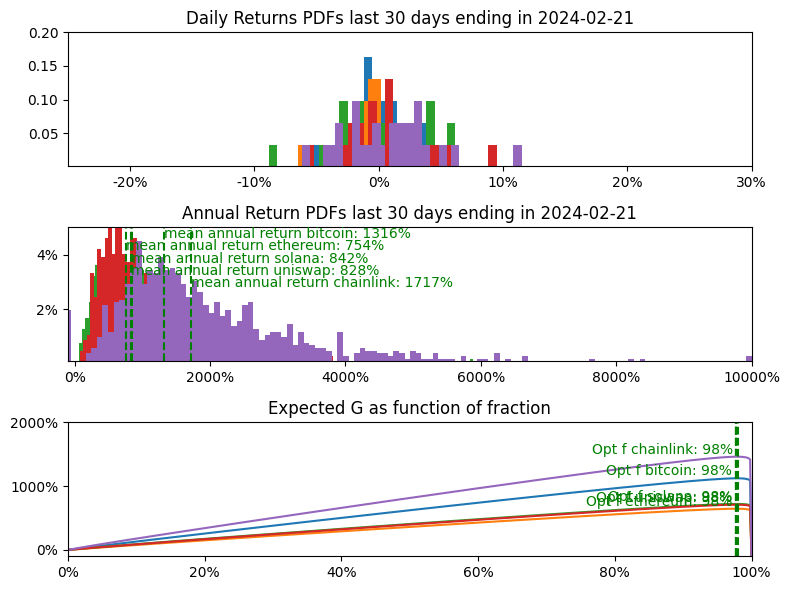

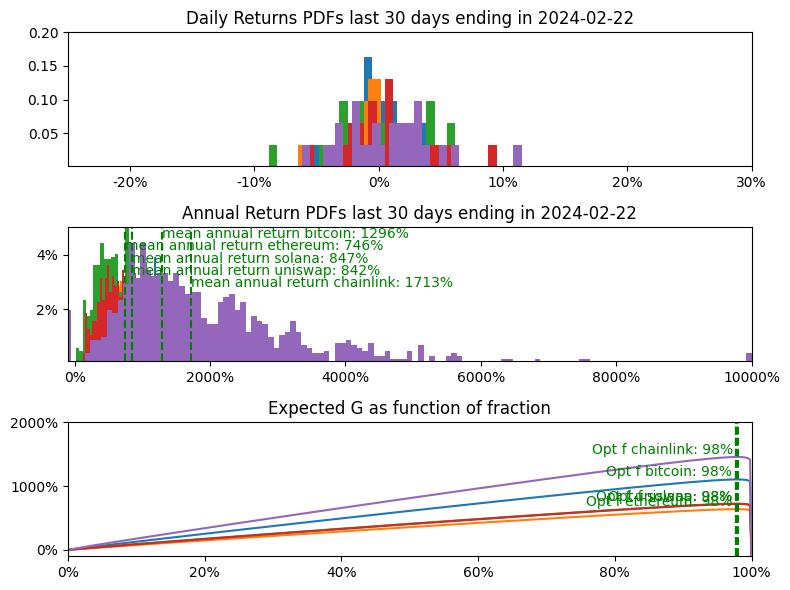

In [236]:
calc_date = pd.to_datetime('2024-02-20').date()
# tail = 100
montecarlo_simulations = 1000
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']
min_x = -1
max_x = 100
bins_yearly = 120
min_x_daily = -0.5
max_x_daily = 1.5
bins_daily = 600
bin_kelly_fractions = 500

swan_size = -1
swan_frequency = 1/50
# y_max = 0.3

information_window_tail_days = 30


for i in range(3):  # For each of the three days
    new_date = calc_date + timedelta(days=i)
    frame_prefix = new_date.strftime("%Y-%m-%d")
    get_3charts(new_date,merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,frame_prefix)

In [239]:
%pip install imageio[ffmpeg]

  Using cached imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.metadata (1.7 kB)
Using cached imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl (22.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [240]:
import imageio

filenames = [f"{(calc_date + timedelta(days=i)).strftime('%Y-%m-%d')}_ax1.png" for i in range(3)]
# Include all generated frame filenames in the list above

with imageio.get_writer('charts.mp4', fps=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [94]:
merged_df_annualized.head(10)

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,...,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return,bitcoin_yearly_return,ethereum_yearly_return,solana_yearly_return,uniswap_yearly_return,chainlink_yearly_return
2970,2024-01-22,41541.899457,15.408740,2454.909543,91.162356,6.371486,-0.002023,-0.002025,-0.006216,-0.006235,...,-0.015537,-0.014719,-0.014829,-0.019981,-0.020183,1.360454,-0.930644,4.719421,-0.917625,-0.393539
2971,2024-01-23,39504.730058,14.515962,2307.587003,83.436233,6.020439,-0.049039,-0.050282,-0.060011,-0.061888,...,-0.088559,-0.055097,-0.056672,-0.057940,-0.059686,1.396111,-0.927926,4.187437,-0.920661,-0.410535
2972,2024-01-24,39833.454105,14.265855,2241.942776,84.097712,5.840927,0.008321,0.008287,-0.028447,-0.028860,...,0.007897,-0.029817,-0.030271,-0.017230,-0.017380,1.360803,-0.928552,4.525865,-0.916264,-0.396465
2973,2024-01-25,40123.671058,14.239486,2236.739313,88.974038,5.872442,0.007286,0.007259,-0.002321,-0.002324,...,0.056365,0.005396,0.005381,-0.001848,-0.001850,1.361052,-0.929271,4.341031,-0.919255,-0.409458
2974,2024-01-26,39938.286442,13.786360,2219.614527,86.983350,5.750225,-0.004620,-0.004631,-0.007656,-0.007686,...,-0.022628,-0.020812,-0.021032,-0.031822,-0.032339,1.355158,-0.926958,4.396669,-0.919806,-0.388462
2975,2024-01-27,41862.935611,14.188129,2268.870732,92.364751,5.948574,0.048191,0.047065,0.022191,0.021949,...,0.060029,0.034494,0.033913,0.029142,0.028726,1.397353,-0.927243,4.798124,-0.917271,-0.394757
2976,2024-01-28,42119.610495,14.342950,2267.907852,94.074186,5.990690,0.006131,0.006113,-0.000424,-0.000424,...,0.018338,0.007080,0.007055,0.010912,0.010853,1.365326,-0.929918,4.387394,-0.919352,-0.375368
2977,2024-01-29,42026.578562,14.488637,2257.054465,95.966566,5.947057,-0.002209,-0.002211,-0.004786,-0.004797,...,0.019916,-0.007284,-0.007310,0.010157,0.010106,1.397802,-0.927801,4.435625,-0.921942,-0.415710
2978,2024-01-30,43267.609276,14.986884,2314.594728,101.419996,6.140105,0.029530,0.029102,0.025494,0.025174,...,0.055270,0.032461,0.031945,0.034389,0.033811,1.383692,-0.930280,4.239889,-0.920804,-0.409307
2979,2024-01-31,42892.034530,15.437438,2344.001400,101.491123,6.259800,-0.008680,-0.008718,0.012705,0.012625,...,0.000701,0.019494,0.019306,0.030063,0.029620,1.321228,-0.929576,4.428586,-0.917040,-0.406654


In [80]:
merged_df.head()
merged_copy = merged_df.copy()
# we make Date into date format
merged_copy['Date'] = pd.to_datetime(merged_df['Date'])
merged_copy.tail(5)


,Date,spy_close,spy_daily_return,spy_daily_log1_return,btc_close,btc_daily_return,btc_daily_log1_return,spy_yearly_return,btc_yearly_return
8885,2024-02-14,498.570007,0.009088,0.009047,51826.695312,0.041901,0.041047,0.570288,12.333038
8886,2024-02-15,502.010010,0.006900,0.006876,51938.554688,0.002158,0.002156,0.769715,10.953342
8887,2024-02-16,499.510010,-0.004980,-0.004992,52160.203125,0.004268,0.004258,0.753415,12.208295
8888,2024-02-17,NaN,NaN,NaN,51662.996094,-0.009532,-0.009578,0.700660,18.053204
8889,2024-02-18,NaN,NaN,NaN,51745.488281,0.001597,0.001595,0.450491,18.762846


In [165]:
def get_exp_g(merged_df, f_spy, f_btc,swan_size,swan_frequency, date, window):
    # we make sure the date is a timestamp
    date = pd.to_datetime(date)
    # print('Date 1: ', date)
    # same with the column
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    samples_df = merged_df[(merged_df['Date'] >= date - pd.DateOffset(months=window)) & (merged_df['Date'] <= date)]
    samples_df = samples_df[['spy_yearly_return', 'btc_yearly_return']]
    # samples_df = samples_df.dropna()
    n_samples = samples_df.shape[0]
    # print('n_samples: ', n_samples)
    weights = np.ones(n_samples) / n_samples
    # we add a row to the samples_df if swan_frequency > 0 with the swan_size and swan_frequency
    if swan_frequency > 0:
        # we prepare a new row which has the swan size for each column
        new_row = pd.DataFrame({'spy_yearly_return': swan_size, 'btc_yearly_return': swan_size}, index=[samples_df.index[-1]+1])
        samples_df = pd.concat([samples_df,new_row], ignore_index=True)
        n_samples += 1
        weights = weights * (1 - swan_frequency)
        weights = np.append(weights, swan_frequency)
    # we add the weights to the samples_df
    samples_df['weights'] = weights


    # print('swan size and frequency: ', swan_size, swan_frequency)
    # print('sum of weights: ', np.sum(weights))
    
    #  we create a column with the blend of the spy and btc returns using the f_spy and f_btc
    samples_df['portfolio_blend_return'] = f_spy * samples_df['spy_yearly_return'] + f_btc * samples_df['btc_yearly_return']
    samples_df['portfolio_blend_return_log1p'] = np.log1p(samples_df['portfolio_blend_return'])

    exp_g = np.dot(samples_df['portfolio_blend_return_log1p'], samples_df['weights'])

    # we do exp minus 1 of exp_g

    exp_g = np.expm1(exp_g)
    
    # print('Expected G: ', exp_g)

    # return samples_df # exp_g
    return exp_g #, samples_df # exp_g

# get_exp_g(merged_df, 0.7, 0.3, -1, 0.1, pd.Timestamp('2023-10-01'), 1).tail(5)

    

In [260]:
merged_df['spy_close'].fillna(method='ffill', inplace=True)
merged_df['btc_close'].fillna(method='ffill', inplace=True)

In [259]:
merged_df.tail(10)

,Date,spy_close,spy_daily_return,spy_daily_log1_return,btc_close,btc_daily_return,btc_daily_log1_return,spy_yearly_return,btc_yearly_return,spy_yearly_return_log1p,btc_yearly_return_log1p
8880,2024-02-09,5012.000122,0.005779,0.005763,47147.199219,0.040741,0.039933,0.919244,0.184809,0.517923,0.941154
8881,2024-02-10,5012.000122,NaN,NaN,47771.277344,0.013237,0.013150,1.142412,0.550416,0.502768,1.005692
8882,2024-02-11,5012.000122,NaN,NaN,48293.917969,0.010940,0.010881,1.057169,3.506879,0.412810,0.892882
8883,2024-02-12,5009.800110,-0.000146,-0.000146,49958.222656,0.034462,0.033881,0.879447,6.392270,0.353410,1.047406
8884,2024-02-13,4940.799866,-0.013773,-0.013869,49742.441406,-0.004319,-0.004329,0.509701,8.959066,0.281853,1.146573
8885,2024-02-14,4985.700073,0.009088,0.009047,51826.695312,0.041901,0.041047,0.554905,12.252056,0.304049,1.373235
8886,2024-02-15,5020.100098,0.006900,0.006876,51938.554688,0.002158,0.002156,0.771481,11.275370,0.333402,1.587046
8887,2024-02-16,4995.100098,-0.004980,-0.004992,52160.203125,0.004268,0.004258,0.751662,12.622708,0.282353,1.406564
8888,2024-02-17,4995.100098,NaN,NaN,51662.996094,-0.009532,-0.009578,0.675347,18.392929,0.252652,1.388011
8889,2024-02-18,4995.100098,NaN,NaN,51745.488281,0.001597,0.001595,0.435841,18.420927,0.344362,1.247298


In [282]:
def add_swan(bin_centers, counts, swan_size, swan_frequency):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    if swan_frequency > 0:
        bin_centers.append((swan_size))
        counts.append(swan_frequency)
        counts = np.array(counts) / np.sum(counts)
    # bin_centers_spy = np.sort(bin_centers_spy)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)
    return bin_centers, counts


In [284]:
def add_log_swan(bin_centers, counts, swan_size, swan_frequency, swan_f):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    if swan_frequency > 0:
        bin_centers.append(np.log1p(swan_size*swan_f))
        counts.append(swan_frequency)
        counts = np.array(counts) / np.sum(counts)
        
    return bin_centers, counts


In [285]:
def get_kelly_exp_g(month_data_spy,merged_df_annualized, date, resolution, swan_size, swan_frequency, offset_months,bins,max_x,min_x):
        fr = np.linspace(0,1,50)
        bin_centers_spy, counts_spy, bin_width_spy = get_pdf(month_data_spy, bins, min_x, max_x)
       
        exp_g_array = []
        for f in fr:
            bin_centers_spy_f = bin_centers_spy * f
            log_centers = np.log1p(bin_centers_spy_f).tolist()
            counts = counts_spy.tolist()
            log_centers, counts = add_log_swan(log_centers, counts, swan_size, swan_frequency)

            exp_g = np.dot(log_centers, counts)
            exp_g = np.expm1(exp_g)
            exp_g_array.append(exp_g)

        from scipy.ndimage import gaussian_filter1d
        exp_g_array = gaussian_filter1d(exp_g_array, sigma=0.5)
        return exp_g_array

In [283]:
def calc_optimal_2assets(merged_df, resolution, bin_centers, counts, swan_size, swan_frequency, date, offset_months):
    f_spy = np.linspace(0,1,resolution)
    f_btc = np.linspace(0,1,resolution)
    # exp_g_array = []
    # we defined exp_g_matrix as a matrix of zeros
    exp_g_matrix = np.zeros((len(f_spy), len(f_btc)))
    optimal_f_btc = []
    optimal_f_spy = []
    # range_f_btc = np.linspace(0,1,61)

    # we create a dataframe with the f_spy as index and f_btc as columns
    exp_g_df = pd.DataFrame(index=f_spy, columns=f_btc)

    bin_centers_btc, bin_centers_spy = bin_centers
    counts_btc, counts_spy = counts
    
    bin_centers_btc, counts_btc = add_swan(bin_centers_btc, counts_btc, swan_size, swan_frequency)
    bin_centers_spy, counts_spy = add_swan(bin_centers_spy, counts_spy, swan_size, swan_frequency)


    # for each row and column of the dataframe we calculate the expected G by multiplying the f_spy and f_btc by the pdfs and summing the results
    for i in range(len(f_spy)):
        for j in range(len(f_btc)):
            if f_spy[i] + f_btc[j] > 1:
                exp_g_matrix[i, j] = np.nan
                continue
            else:
                exp_g = get_exp_g(merged_df, f_spy[i], f_btc[j], swan_size, swan_frequency, date, offset_months)
                exp_g_matrix[i, j] = exp_g
                exp_g_df.iloc[i, j] = exp_g

    # we look for the optimal f_spy and f_btc by looking for the maximum exp_g in the matrix
    max_exp_g_index = exp_g_df.idxmax()

    # we get the indexes of the max_exp_g
    max_value = exp_g_df.max().max()
    max_exp_g_index = np.where(exp_g_matrix == max_value)

    # we extract from the tuple the indexes of the max_exp_g
    max_exp_g_index = list(zip(max_exp_g_index[0], max_exp_g_index[1]))
    
    try:
        index_s, index_b = max_exp_g_index[0]
    except:
        print('ERROR')
        index_s, index_b = 0, 0
    
    optimal_f_spy = f_spy[index_s]
    optimal_f_btc = f_btc[index_b]
    return optimal_f_spy, optimal_f_btc

In [281]:
# we try to fix the matrix calculation, to make the sum inside the log1p


# we manually inject a catastrophic event in the spy returns and the btc returns
# we hide warnings
import warnings
warnings.filterwarnings('ignore')


def update8(date, merged_df_annualized, month_starts, min_x=-0.4, max_x=0.4, y_max=1, bins=50, swan_size=0, swan_frequency=0, resolution = 10):
        # Ensure the 'Date' column is in datetime format
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    date = pd.to_datetime(date)

    print('======  ENTERING CHART LOOP =========')
    print('date: ', date)

    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    ax7.clear()
    ax8.clear()
    ax9.clear()


    month_data_spy = merged_df[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['spy_yearly_return']
    month_data_spy_log = merged_df[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['spy_yearly_return_log1p']

    if not month_data_spy.empty:
        bin_centers_spy_0, counts_spy_0, bin_width_spy = get_pdf(month_data_spy, bins, min_x, max_x)
        bin_centers_spy, counts_spy = add_swan(bin_centers_spy_0, counts_spy_0, swan_size, swan_frequency)
        mean_spy = np.dot(bin_centers_spy, counts_spy)
        mean_spy_text = mean_spy * 100


        ax1.bar(bin_centers_spy, counts_spy, width=bin_width_spy, align='center')  # align='center' to center the bars
        ax1.set_title(f"SPY PDF trailing {offset_months} months")
        ax1.set_xlim(min_x, max_x)
        ax1.set_ylim(0.001, y_max)
        ax1.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax1.axvline(x=mean_spy, color='g' if mean_spy > 0 else 'r', linestyle='--', label='Mean return')
        ax1.text(mean_spy, 0.4, f"Mean: {mean_spy_text:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g' if mean_spy > 0 else 'r')
        ax1.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax1.set_xlabel('Annual SPY return')
        ax1.set_ylabel('Probability Density')

        bin_centers_spy_0, counts_spy_0, bin_width_spy = get_pdf(month_data_spy_log, bins, min_x, max_x)
        bin_centers_spy, counts_spy = add_swan(bin_centers_spy, counts_spy, swan_size, swan_frequency)
        mean_spy = np.dot(bin_centers_spy, counts_spy)
        mean_spy = np.expm1(mean_spy)
        bin_centers_spy = np.clip(bin_centers_spy, min_x, max_x)
        

        ax3.bar(bin_centers_spy, counts_spy, width=bin_width_spy, align='center')  # align='center' to center the bars
        ax3.set_title(f"SPY PDF trailing {offset_months} months (log)")
        ax3.set_xlim(min_x, max_x)
        ax3.set_ylim(0.001, y_max)
        ax3.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax3.axvline(x=mean_spy, color='g' if mean_spy > 0 else 'r', linestyle='--', label='Mean return')
        mean_spy = mean_spy * 100
        ax3.text(mean_spy/100 if mean_spy > -100 else -1, 0.4, f"Mean: {mean_spy:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g' if mean_spy > 0 else 'r')
        ax3.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax3.set_xlabel('Log (1 + Annual BTC return)')


        exp_g_array = get_kelly_exp_g(month_data_spy,merged_df_annualized, date, resolution, swan_size, swan_frequency, offset_months,bins,max_x,min_x)

        ax5.plot(fr, exp_g_array)  # Fix: Change ax5.line() to ax5.plot()
        ax5.set_title(f"Expected G as f of fraction (SPY)")
        ax5.set_xlim(0, 1)
        # ax5.set_ylim(0, 1)
        ax5.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        max_g = np.max(exp_g_array)
        max_f = fr[np.argmax(exp_g_array)]
        ax5.axvline(x=max_f, color='g', linestyle='--', label='Max G')
        ax5.text(max_f, max_g if max_g < 1 else 1, f"Opt f: {max_f*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g')
        ax5.set_ylim(-1,1)
        ax5.set_xlabel('Fraction of capital into SPY')


    else:
        print('No data for SPY', date)


    month_data_btc = merged_df[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['btc_yearly_return']
    month_data_btc_log = merged_df[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['btc_yearly_return_log1p']
    if not month_data_btc.empty:
        bin_centers_btc_0, counts_btc_0, bin_width_btc = get_pdf(month_data_btc, bins, min_x, max_x)

        bin_centers_btc = bin_centers_btc_0.tolist()
        counts_btc = counts_btc_0.tolist()
        if swan_frequency > 0:
            # swan_size = -0.999999999999999999999999999999999 if swan_size == -1 else swan_size
            bin_centers_btc.append((swan_size))
            counts_btc.append(swan_frequency)
            # we normalize the array_2
            counts_btc = np.array(counts_btc) / np.sum(counts_btc)

        bin_centers_btc_01 = bin_centers_btc
        counts_btc_01 = counts_btc

        # bin_centers_btc = np.log1p(bin_centers_btc)
        ax2.bar(bin_centers_btc, counts_btc, width=bin_width_btc, align='center')  # align='center' to center the bars
        ax2.set_title(f"BTC PDF trailing {offset_months} months")
        ax2.set_xlim(min_x, max_x)
        ax2.set_ylim(0.001, y_max)
        ax2.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        mean_btc = np.dot(bin_centers_btc, counts_btc)
        mean_btc_text = mean_btc * 100
        # mean_btc = np.expm1(365*mean_btc)
        ax2.axvline(x=mean_btc, color='g' if mean_btc > 0 else 'r', linestyle='--', label='Mean return')
        ax2.text(mean_btc, 0.4, f"Mean: {mean_btc_text:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g' if mean_btc > 0 else 'r')
        ax2.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        # set x axis label to 'Annual BTC return'
        ax2.set_xlabel('Annual BTC return')
        ax2.set_ylabel('Probability Density')

        
        bin_centers_btc_0, counts_btc_0, bin_width_btc = get_pdf(month_data_btc_log, bins, min_x, max_x)
        bin_centers_btc = bin_centers_btc_0.tolist()
        counts_btc = counts_btc_0.tolist()
        # bin_centers_btc = np.log1p(bin_centers_btc)
        # bin_centers_btc_backup = bin_centers_btc
        # bin_centers_btc_backup = [x*0.9 for x in bin_centers_btc_backup]

        # bin_centers_btc = np.log1p(bin_centers_btc_0).tolist()
        # bin_centers_btc_2 = np.log1p(bin_centers_btc_backup).tol
        list()
        counts_btc = counts_btc_0.tolist()

        if swan_frequency > 0:
            # swan_size = -0.999999999999999999999999999999999 if swan_size == -1 else swan_size
            # bin_centers_btc.append(np.log1p(swan_size))
            counts_btc.append(swan_frequency)
            # we normalize the array_2
            counts_btc = np.array(counts_btc) / np.sum(counts_btc)
            bin_centers_btc.append(np.log1p(swan_size*0.95))

        mean_btc = np.dot(bin_centers_btc, counts_btc)
        mean_btc = np.expm1(mean_btc)

        bin_centers_btc = np.clip(bin_centers_btc, min_x, max_x)

        # exp_g = np.dot(array_1, array_2)
        ax4.bar(bin_centers_btc, counts_btc, width=bin_width_btc, align='center')  # align='center' to center the bars
        ax4.set_title(f"BTC PDF of trailing {offset_months} months (log)")
        ax4.set_xlim(min_x, max_x)
        ax4.set_ylim(0.001, y_max)
        ax4.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

        ax4.axvline(x=mean_btc, color='g' if mean_btc > 0 else 'r', linestyle='--', label='Mean return')
        mean_btc = mean_btc * 100
        ax4.text(mean_btc/100 if mean_btc/100 < max_x else max_x, 0.4, f"Mean: {mean_btc:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g' if mean_btc > 0 else 'r')
        ax4.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        # we set ax4 x axis label to 'Fraction of capital into SPY'
        ax4.set_xlabel('Log (1 + Annual BTC return)')
        



        fr = np.linspace(0,1,50)
        # print('here are fr: ',fr)
        # bin_centers_btc, counts_btc, bin_width_btc = get_pdf(month_data_btc, bins, min_x, max_x, swan_size=swan_size, swan_frequency=swan_frequency)
        # print('bin centers ', bin_centers_spy)
       
        exp_g_array = []
        for f in fr:
            bin_centers_btc_f = bin_centers_btc_0 * f
            # bin_centers_btc_f = np.log1p(bin_centers_btc_f)
            # print('bin centers post times f: ', bin_centers_spy_f)
            # print('counts_spy: ', counts_spy)
            # print('log1p bin centers', np.log1p(bin_centers_spy_f))
            array_1 = np.log1p(bin_centers_btc_f).tolist()
            array_2 = counts_btc_0.tolist()
            if swan_frequency > 0:
                # swan_size = -0.999999999999999999999999999999999 if swan_size == -1 else swan_size
                array_1.append(np.log1p(swan_size*f))
                array_2.append(swan_frequency)
                # we normalize the array_2
                array_2 = np.array(array_2) / np.sum(array_2)

            exp_g = np.dot(array_1, array_2)
            exp_g = np.expm1(exp_g)
            exp_g_array.append(exp_g)
        
        # print('exp g array: ', exp_g_array)

        # we smooth the exp_g_array
        exp_g_array = gaussian_filter1d(exp_g_array, sigma=0.5)

        ax6.plot(fr, exp_g_array)  # Fix: Change ax5.line() to ax5.plot()
        ax6.set_title(f"Expected G as f of fraction (BTC)")
        ax6.set_xlim(0, 1)
        # ax5.set_ylim(0, 1)
        ax6.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        max_g = np.max(exp_g_array)
        max_f = fr[np.argmax(exp_g_array)]
        ax6.axvline(x=max_f, color='g', linestyle='--', label='Max G')
        ax6.text(max_f, max_g if max_g < 1 else 1, f"Opt f: {max_f*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right', color='g')
        ax6.set_ylim(-1,1)
        # we set ax6 x axis label to 'Fraction of capital into BTC'
        ax6.set_xlabel('Fraction of capital into BTC')



    else:
        print('No data for BTC', date)

    optimal_f_spy, optimal_f_btc = calc_optimal(merged_df, resolution, (bin_centers_btc_01, bin_centers_spy_0), (counts_btc_01, counts_spy_0), swan_size, swan_frequency, date, offset_months)
    
    # we create a scatter plot on ax7 that has a dot at the optimal f_spy and f_btc
    ax7.scatter(optimal_f_btc,optimal_f_spy,color='r', label='Optimal f_spy and f_btc', s=300)
    # we make the dot bigger


    # we get the f_btc that generated the max exp_g
    ax7.axvline(x=optimal_f_btc, color='r', linestyle='--', label='Max G')
    ax7.axhline(y=optimal_f_spy, color='r', linestyle='--', label='Max G')
    ax7.text(optimal_f_btc, optimal_f_spy if optimal_f_spy < 1 else 1, f"Optimal BTC: {optimal_f_btc*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right' if optimal_f_btc > 0.5 else 'left', color='r')
    ax7.text(optimal_f_btc, optimal_f_spy+0.1 if optimal_f_spy < 1 else 1, f"Optimal SPY: {optimal_f_spy*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right' if optimal_f_btc > 0.5 else 'left', color='b')
    ax7.text(optimal_f_btc, optimal_f_spy+0.2 if optimal_f_spy < 1 else 1, f"Optimal Cash: {(1-optimal_f_btc-optimal_f_spy)*100:.0f}%", rotation=0, verticalalignment='bottom', horizontalalignment='right' if optimal_f_btc > 0.5 else 'left', color='black')

    ax7.set_title(f"Optimal fractions of BTC and SPY")
    ax7.set_xlim(-0.1, 1.1)
    ax7.set_ylim(-0.1, 1.1)
    ax7.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax7.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax7.set_xlabel("% of BTC in the portfolio")
    ax7.set_ylabel('% of SPY in the portfolio')
    ax7.grid(True)
    # we set y axis blue and x axis red
    ax7.yaxis.label.set_color('blue')
    ax7.xaxis.label.set_color('red')
    ax7.tick_params(axis='x', colors='red')
    ax7.tick_params(axis='y', colors='blue')

    
    from matplotlib.colors import LinearSegmentedColormap

    # show a heatmap of exp_g_df on ax8
    # we create a custom colormap
    cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'white', 'red'])
    # we create a norm that goes from the min to the max of the exp_g_df
    norm = plt.Normalize(exp_g_df.min().min(), exp_g_df.max().max())
    # we plot the heatmap of the dataframe, to make sure column and row labels are shown we set x and y to True
    ax8.imshow(exp_g_matrix, cmap='viridis',  interpolation='nearest')
    ax8.set_title(f"Portfolio E(G) as f(%BTC, %SPY)")
    ax8.set_xlabel("% of BTC in the portfolio")
    ax8.set_ylabel("% of SPY in the portfolio")

    tick_positions = ax8.get_xticks()
    tick_labels_temp = []
    for i, pos in enumerate(tick_positions):
        tick_labels_temp.append(f"{pos/resolution:.0f}%")
    tick_labels = tick_labels_temp

    # heatmap_steps = int(resolution // 5)
    # print('heatmap_steps: ', heatmap_steps)
    heatmap_labels = [f"{i:.0f}%" for i in range(0, 101, 20)]
    heatmap_ticks = [i*resolution//5 for i in range(0, 6)]
    # print('heatmap_ticks: ', heatmap_ticks)
    # print('heatmap_labels: ', heatmap_labels)
    ax8.set_xticks(heatmap_ticks)
    ax8.set_xticklabels(heatmap_labels)

    ax8.set_yticks(heatmap_ticks)
    ax8.set_yticklabels(heatmap_labels)

    # ax8.set_xticks(tick_positions)
    # ax8.set_xticklabels(tick_labels)
    # we hide the axis values in ax8
    # ax8.set_xticks([])
    # ax8.set_yticks([])
    # ax8.set_xticklabels(f_btc*100)
    # ax8.set_yticklabels(f_spy*100)
    # ax8.set_yticks(tick_positions)
    # ax8.set_yticklabels(tick_labels)

    # makex y axis and y ticks blue
    ax8.yaxis.label.set_color('blue')
    ax8.xaxis.label.set_color('red')

    

    # # we make the axis line and ticks red
    # for spine in ax8.spines.values():
    #     spine.set_edgecolor('red')
    ax8.tick_params(axis='x', colors='red')
    ax8.tick_params(axis='y', colors='blue')

    # we reverse the y axis
    ax8.invert_yaxis()

    # ax8.set_xlim(0, 9)
    # ax8.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    # ax8.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    # ax8.set_xticks(f_btc)
    # ax8.set_yticks(f_spy)
    # ax8.grid(True)

    # on ax9 we plot the close prices of spy and btc at the end of the period. On the x axis we have date, and then we plot SPY on y1 and btc on y2
    spy_close_gray = merged_df_annualized['spy_close'].to_list()
    btc_close_gray = merged_df_annualized['btc_close'].to_list()
    dates_gray = merged_df_annualized['Date'].to_list()
    spy_close = merged_df_annualized[merged_df_annualized['Date'] <= date]['spy_close'].to_list()
    btc_close = merged_df_annualized[merged_df_annualized['Date'] <= date]['btc_close'].to_list()
    dates = merged_df_annualized[merged_df_annualized['Date'] <= date]['Date'].to_list()
    # transform the dates to strings format Y-m-d
    dates = [date.strftime('%Y-%m-%d') for date in dates]
    dates_gray = [date.strftime('%Y-%m-%d') for date in dates_gray]
    # print('dates: ', dates) 
    # print('spy_close: ', spy_close)
    # print('btc_close: ', btc_close)
    # print('len dates: ', len(dates))
    # print('len spy_close: ', len(spy_close))
    # print('len btc_close: ', len(btc_close))
    # ax9.plot(dates, spy_close, 'b-', label='SPY')
    # ax9.plot(dates, btc_close, 'r-', label='BTC')
    # ax9.set_title(f"Close prices for {date.strftime('%Y-%m')}")
    # ax9.set_xlabel("Date")
    # ax9.set_ylabel("Close price")
    # ax9.legend()


    
    date1 = month_starts[0]
    # we get the index of the date1 in the dates_gray
    index_date1_gray = dates_gray.index(date1.strftime('%Y-%m-%d'))
    # print(dates)
    index_date1 = dates.index(date1.strftime('%Y-%m-%d'))
    # print('len dates_gray: ', len(dates_gray))
    # print('len spy_close_gray: ', len(spy_close_gray))
    # print('index_date1: ', index_date1)
    # print(spy_close_gray)
    # print(spy_close_gray[index_date1])
    spy_day1 = spy_close_gray[index_date1_gray]
    # print('spy_day1: ', spy_day1)   

    while np.isnan(spy_day1):
        print('Trying to normalize charts. Looking for SPY reference since day 1 is NaN')
        index_date1 -= 1
        spy_day1 = spy_close_gray[index_date1]
        # print('new index1', index_date1)
    # print('new indexF', index_date1)
    print('Baseline SPclose found at:', spy_close_gray[index_date1])
   
    spy_close = np.array(spy_close) / spy_close_gray[index_date1]
    btc_close = np.array(btc_close) / btc_close_gray[index_date1]
    spy_close_gray = np.array(spy_close_gray) / spy_close_gray[index_date1]
    btc_close_gray = np.array(btc_close_gray) / btc_close_gray[index_date1]



    ax9.clear()
    # ax9b.clear()
    ax9.plot(dates_gray, spy_close_gray, color = 'grey')
    # print('len dates_gray: ', len(dates_gray))
    # print('len spy_close_gray: ', len(spy_close_gray))
    # print('len btc_close_gray: ', len(btc_close_gray))
    # print('len btc_close: ', len(btc_close))
    # print('len spy_close: ', len(spy_close))
    # # we complete spy_close with nan values to make it the same length as dates_gray
    # make spy_close into a list
    spy_close = spy_close.tolist()
    spy_close.extend([np.nan] * (len(dates_gray) - len(spy_close)))
    # make it back to np array
    # spy_close = [np.array(spy_close)]
    # print('len dates_gray: ', len(dates_gray))
    # print('len spy_close: ', len(spy_close))


    dates_gray_b = [pd.to_datetime(date) for date in dates_gray]
    # print('dates_gray: ', dates_gray_b)
    dates_gray_labels = [date.strftime('%m-%y') for date in dates_gray_b]
    # print('dates_gray_labels: ', dates_gray_labels)
    # print('len dates_gray_labels: ', len(dates_gray_labels) )

    ax9.plot(dates_gray, spy_close, 'b-', label='SPY')
    ax9.set_xlabel("Date")
    ax9.set_ylabel("SPY Close Price", color='b')
    ax9.tick_params(axis='y', labelcolor='b')
    ax9.set_title(f"Close prices for {date.strftime('%Y-%m')}")
    # we make x axis ticks to be at month_starts
    # we make a string version of the month_starts
    # month_starts_str = [date.strftime('%Y-%m') for date in month_starts]
    # ax9.set_xticks(month_starts_str)
    # we set x axis ticks to be one per month
    # we detect all month starts that are in the dates
    # month_starts_dates = [date for date in dates if date[-2:] == '01']
    # we update format of month_starts_dates to bt Y-m
    # month_starts_dates = [date[:-3] for date in month_starts_dates]
    # we set the x axis ticks to be at the month_starts_dates
    # print(dates)
    # we convert dates_gray to datetime 
    # ax9.set_xticks(dates_gray_labels[::1400])
    # ax9.set_xticks(month_starts_dates)
    # we set the x ticklabels to be dates_gray_labels
    
    

    
    # btc_close = btc_close + [np.nan]*(len(dates_gray) - len(btc_close))
    btc_close = btc_close.tolist()
    btc_close.extend([np.nan] * (len(dates_gray) - len(btc_close)))
    # print('len dates_gray: ', len(dates_gray))
    # print('len btc_close: ', len(btc_close))
    # Create a secondary y-axis for the BTC close prices (right)
    
 
    
    ax9b.plot(dates_gray, btc_close_gray, color = 'grey')
    ax9b.plot(dates_gray, btc_close, 'r-', label='BTC')
    ax9b.set_ylabel("BTC Close Price", color='r', fontdict={'color': 'r', 'size': 12})
    # we make ax9b ticklabels size 12
    ax9b.set_yticklabels(ax9b.get_yticks(), size=12 , color='r')
    # we format the y2 axis to have no decimal places and a thousand separator
    import matplotlib.ticker as ticker
    ax9b.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    # ax9b.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    # ax9b.tick_params(axis='y', labelcolor='r')

    # we set x axis ticks to be one per month
    # print('len dates_gray: ', len(dates_gray))
    step = int(len(dates_gray) // 4)
    # print('step: ', step)   
    # print('dates_gray_stepped: ', dates_gray[::step])   
    dates_gray_stepped = dates_gray[::step]
    # we append the last date to the list of dates_gray_stepped
    dates_gray_stepped.append(dates_gray[-1])
    ax9.set_xticks(dates_gray_stepped)    
    ax9b.set_xticks(dates_gray_stepped)

    dates_gray_labels = [date.strftime('%m-%y') for date in dates_gray_b]
    dates_gray_labels_stepped = dates_gray_labels[::step]
    dates_gray_labels_stepped.append(dates_gray_labels[-1])
    # print('dates_gray_labels_stepped: ', dates_gray_labels_stepped)
    ax9.set_xticklabels(dates_gray_labels_stepped)
    ax9b.set_xticklabels(dates_gray_labels_stepped)

    # we add a legend to the plot

    

    # we add a shaded area to the plot that only includes these dates: merged_df[(merged_df['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df['Date'] < date)]['Date']
    first_date = merged_df_annualized[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['Date'].iloc[0]
    last_date = merged_df_annualized[(merged_df_annualized['Date'] >= date - pd.DateOffset(months=offset_months)) & (merged_df_annualized['Date'] < date)]['Date'].iloc[-1]
    # we convert the dates to strings Y-m
    first_date = first_date.strftime('%Y-%m-%d')
    last_date = last_date.strftime('%Y-%m-%d')
    # print('first_date: ', first_date)
    # print('last_date: ', last_date)
    ax9.axvspan(first_date, last_date, alpha=0.5, color='grey')
    # we find the max spy_close
    max_spy_close = max(spy_close_gray)
    max_btc_close = max(btc_close_gray)
    max_close = max(max_spy_close, max_btc_close)
    ax9.set_ylim(0, max_close*1.1)
    ax9b.set_ylim(0, max_close*1.1)

    future_spy_signal = optimal_f_spy
    future_btc_signal = optimal_f_btc

    previous_spy_signal = optimal_spy_signals[-1]
    previous_btc_signal = optimal_btc_signals[-1]

    # we append the future signals to the list of signals
    optimal_spy_signals.append(future_spy_signal)
    optimal_btc_signals.append(future_btc_signal)


# we compute the return of the portfolio according to the optimal f_spy and f_btc
    # we get the returns of spy and btc for the date
    # we look what is the immediately previous date in month_starts to date
    # we look for the index of the previous date
    # we look for the index of date
    # index_date = month_starts.index(date)
    # condiering month_starts is a numpy array we look for the index of date
    # print('date: ', date)
    # get date in datetime format and convert it to string format Y-m-d
    date3 = pd.to_datetime(date).strftime('%Y-%m-%d')
    print('STARTING KELLY PFOLIO RETURN - WE ARE ON DATE: ', date3)
    # print('dates_gray: ', month_starts)
    month_start_str = [date.strftime('%Y-%m-%d') for date in month_starts]
    # index_date = np.where(dates_gray == date)
    # we find the index of the date in dates_gray
    index_date = month_start_str.index(date3)
    print('We are on index_date: ', index_date)
    # print('index_date: ', index_date)
    index_date_previous = index_date - 1
    if index_date_previous < 0:
        # index_date_previous = 0
        print('No previous date. We are at the beginning of the dataset')
        if len(portfolio_returns) == 0:
            portfolio_returns.append(1)

        # continue
    else:
        date_previous = month_starts[index_date_previous]   
        # we make sure date_previous is in datetime format in string format Y-m-d
        date_previous = pd.to_datetime(date_previous).strftime('%Y-%m-%d')
        # print('date_previous: ', date_previous)
        # print('currwent date: ', date3)
        # we convert date_previous to string format Y-m-d
        # date_previous = date_previous.strftime('%Y-%m-%d')
        print('Checking previous month start date: ', date_previous)
        # we get the index of the previous date in dates_gray
        index_date_previous = dates_gray.index(date_previous)
        print('index_date_previous: ', index_date_previous)
        # print('date_previous: ', date_previous)
        # we get the spy and btc returns for the previous date
        # we get the close prices for the previous date
        # print('len spy_close_gray: ', len(spy_close_gray))
        # print('index_date_previous: ', index_date_previous)
        prev_spy_close = spy_close_gray[index_date_previous]
        prev_btc_close = btc_close_gray[index_date_previous]
        closest_date = dates_gray[index_date_previous]
        # while np.isnan(prev_spy_close):
        #     print('Looking for SPY reference for PREVIOUS CLOSE')
        #     # we look for the index of closest previous date to date_previous
        #     closest_date = np.argmin([abs(date - date_previous) for date in dates_gray])
        #     closest_date_index = dates_gray.index(closest_date)
        #     index_date_previous = closest_date_index
        #     prev_spy_close = spy_close_gray[closest_date_index]
        print('Previus close:', spy_close_gray[index_date_previous])
        print('Date of previous close: ', dates_gray[index_date_previous])

        date_current = pd.to_datetime(date).strftime('%Y-%m-%d')
        current_index = dates_gray.index(date_current)
        curr_spy_close = spy_close_gray[current_index]
        curr_btc_close = btc_close_gray[current_index]
        date_current = date
       
        # while np.isnan(curr_spy_close):
        #     print('Looking for SPY reference close to that date')
        #     # we look for the index of closest previous date to date_previous
        #     closest_date = np.argmin([abs(date - date_current) for date in dates_gray])
        #     closest_date_index = dates_gray.index(closest_date)
        #     curr_spy_close = spy_close_gray[closest_date_index]
        #     print('Baseline SPclose for current close found at:', dates_gray[closest_date_index])
        #     date_current = dates_gray[closest_date_index]
        print('* Current SPY close: ', curr_spy_close)
        print('* Date of current close: ', date_current)
        print('* Previus close:', spy_close_gray[index_date_previous])
        print('* Date of previous close: ', dates_gray[index_date_previous])

        print('* Current BTC close: ', curr_btc_close)
        print('* Date of current close: ', date_current)
        print('* Previus close:', btc_close_gray[index_date_previous])
        print('* Date of previous close: ', dates_gray[index_date_previous])


        spy_return = (curr_spy_close - prev_spy_close) / prev_spy_close
        btc_return = (curr_btc_close - prev_btc_close) / prev_btc_close
        
        # if spy_return is nan we set it to 1
        if np.isnan(spy_return):
            print('something dididnt work setting to 1 manually')
            spy_return = 0
        print('spy_return: ', spy_return)
        # prev_btc_close = btc_close_gray[index_date_previous]
        # curr_btc_close = btc_close_gray[index_date]
        # btc_return = (curr_btc_close - prev_btc_close) / prev_btc_close
        if np.isnan(btc_return):
            btc_return = 0
        print('btc_return: ', btc_return)
        # we compute the return of the portfolio
        portfolio_return = previous_spy_signal * spy_return + previous_btc_signal * btc_return +1
        print('previous optimal signals spy and btc: ', previous_spy_signal, previous_btc_signal)
        print('percentages of spy and btc: ', optimal_f_spy, optimal_f_btc)
        print('portfolio_return: ', portfolio_return)
        portfolio_returns.append(portfolio_return)
        

    # we create an array with the cumulative returns at each date
    portfolio_returns_cum = np.cumprod(portfolio_returns)
    portfolio_returns_cum_temp = list(portfolio_returns_cum)
    while len(portfolio_returns_cum_temp) < len(month_starts):
        portfolio_returns_cum_temp.append(np.nan)

    portfolio_returns_cum_temp = np.array(portfolio_returns_cum_temp)
    # print('len portfolio_returns_cum_temp: ', len(portfolio_returns_cum_temp))
    
    print('portfolio_returns ', portfolio_returns)
    print('portfolio_returns_cum_temp: ', portfolio_returns_cum_temp)

    # we plot the cumulative returns on ax9. We don't need another y axis, we can use the same because it's normalized to 1
    # we make sure month_starts is in datetime format
    month_starts_2 = [pd.to_datetime(date).date() for date in month_starts]
    # we convert the dates to strings Y-m-d
    month_starts_2 = [date.strftime('%Y-%m-%d') for date in month_starts_2]
    # print('month_starts_2: ', month_starts_2)
    # print('dates_gray: ', dates_gray)
    ax9.plot(month_starts_2, portfolio_returns_cum_temp, 'g-', label='Portfolio')

    # print(month_starts[0])
    x_min = pd.to_datetime(month_starts[0] - pd.DateOffset(months=offset_months)).date()
    # print(x_min)
    # we convert x_min to string format Y-m-d
    x_min = x_min.strftime('%Y-%m-%d')
    ax9.set_xlim(x_min, dates_gray[-1])




    # we annotate a title on the overal plot (not a subplot). We basically write the parameters used for swan, swan frequency, months window, and the start date
    # fig.suptitle(f"Swan size: {swan_size}, Swan frequency: {swan_frequency}, {offset_months} months window, starting in {date.strftime('%Y-%m')}")
    # we make subttitle bigger
    fig.suptitle(f"Params: Date {date.strftime('%Y-%m')}, Trailing Window:  {offset_months} months,  Swan size: {swan_size}, Swan frequency: {swan_frequency} ", fontsize=22)
    plt.subplots_adjust(top=1)
    # we make font of the subtitle bigger
    plt.rcParams.update({'font.size': 13})
    # we increase passing space between subplots
    
    # Adjust the subplot layout parameters
    

    # we update specifically the font size of the subtitle to font size 16
    
    # we set ax3 y axis title to 'Probability Density'
    ax3.set_ylabel('Probability Density')
    ax4.set_ylabel('Probability Density')
    ax5.set_ylabel('Annual Growth Rate')
    ax6.set_ylabel('Annual Growth Rate')
    ax3.set_xlabel('Log (1 + Annual SPY return)')

    

swan_size = -1
# swan_size = 1 - swan_size
swan_frequency = 0.005

resolution = 10
num_months = 60
month_starts = find_month_starts(merged_df, num_months=num_months)

# we keep only the three first elements of month_starts
month_starts = month_starts[3:]

# print('month_starts: ', month_starts    )
offset_months = 4
min_x = -1
max_x = 3
tail = offset_months * 30
start_date = month_starts[0] #- pd.DateOffset(months=offset_months)
montecarlo_simulations = 500

y_max = 0.5
bins = 20


date_test = month_starts[0] #pd.to_datetime('2024-02-01').date()
date_start = date_test - pd.DateOffset(months=offset_months)
date_start = date_start - pd.DateOffset(days=tail)

merged_df_annualized = add_annual_stochastic_returns(date_start, merged_df, (max_x-min_x)*100, tail, montecarlo_simulations)


fig, ((ax1, ax2, ax8), (ax3, ax4, ax7), (ax5,ax6, ax9)) = plt.subplots(3, 3, figsize=(18, 16))
ax9b = ax9.twinx()
plt.subplots_adjust(wspace=0.35, hspace=0.35)
fargs = (merged_df_annualized,month_starts,min_x, max_x, y_max, bins, swan_size, swan_frequency, resolution)
portfolio_returns = []
optimal_spy_signals = [0]
optimal_btc_signals = [0]

# Create the animation
ani = FuncAnimation(fig, update8, frames=month_starts, repeat=False, fargs=fargs)
# render = HTML(ani.to_jshtml())
plt.close(fig)
# render

# we save the animation as a gif
ani.save('restest2.gif', writer='pillow', fps=1)

# we sabe to an mp4
# ani.save('expected_g__pfolio_test4monthswindow60months_lessSWAN.mp4', writer='ffmpeg', fps=2)


======  ENTERING CHART LOOP =========
date:  2019-06-01 00:00:00
Baseline SPclose found at: 2547.9689025878906
STARTING KELLY PFOLIO RETURN - WE ARE ON DATE:  2019-06-01
We are on index_date:  0
No previous date. We are at the beginning of the dataset
portfolio_returns  [1]
portfolio_returns_cum_temp:  [ 1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
======  ENTERING CHART LOOP =========
date:  2019-06-01 00:00:00
Baseline SPclose found at: 2547.9689025878906
STARTING KELLY PFOLIO RETURN - WE ARE ON DATE:  2019-06-01
We are on index_date:  0
No previous date. We are at the beginning of the dataset
portfolio_returns  [1]
portfolio_returns_cum_temp:  [ 1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>